In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

In [4]:
from scipy.interpolate import interp1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error


from tqdm import tqdm

# Dane

In [5]:
DATA_PATH = "Datasets/HCMST 2017 fresh sample for public sharing draft v1.1.dta"

In [6]:
df = pd.read_stata(DATA_PATH)

In [7]:
target = ["S1"]
categorical_features = ['hcm2017q24_internet_other', 'PPT01']
float_features = ['Q16', 'age_when_met']
features = categorical_features + float_features + target

# Preprocessing

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [9]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [10]:
df = df[features]
df = df.dropna()
df[target] = (df[target] == "Yes, I am Married").astype(int)

In [11]:
df_X = df[features[:-1]]
df_y = df[target]

In [12]:
float_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('float', float_transformer, float_features),
        ('cat', categorical_transformer, categorical_features)])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

# Model

In [14]:
fix_params = {'objective': 'binary:logistic', "seed": 42 }
bb_clf_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('clf', XGBClassifier(**fix_params))])

In [15]:
bb_clf_xgb.fit(x_train, y_train)
bb_clf_xgb.score(x_test, y_test)

0.75591985428051

# Residuals

2. Wyznacz reszty dla tego modelu na zbiorze danych uczących.

In [16]:
y_hat = bb_clf_xgb.predict_proba(x_train)[:, 1]
res = y_train.values.flatten() - y_hat
res

array([0.21369064, 0.20642406, 0.10363287, ..., 0.12369698, 0.23264384,
       0.11702526])

# Gam

3. Narysuj wykres kropkowy pokazujący zależność pomiędzy resztą (y - hat y) a wynikiem modelu (hat y).<br> Dodaj krzywą lokalnego trendu (np. loess lub gam) i sprawdź czy różni się od funkcji stale równej zero.

In [17]:
from pygam import LinearGAM
def plot_gam(x, y):
    gam = LinearGAM().fit(x, y)
    lin = np.linspace(x.min(), x.max(), num=100)
    plt.scatter(x,y, c="g", label="residuals")
    plt.scatter(lin, gam.predict(lin), c="r", marker="_", label="trend line")
    plt.legend()
    plt.grid()


In [18]:
def diagnostic_figure(x, y, plot_fn, names):
    plt.figure(figsize=(15, 15))
    plot_fn(x, y)
    plt.title("{} vs {}".format(names[0], names[1]))
    plt.xlabel(names[0])
    plt.ylabel(names[1])

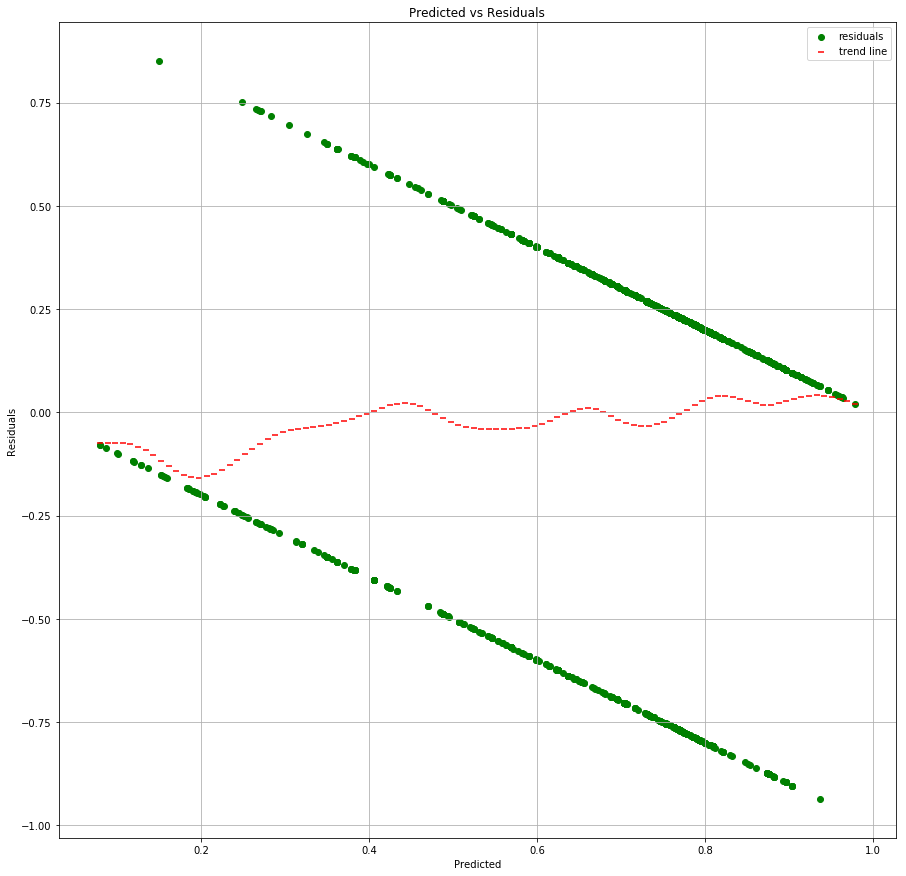

In [19]:
names = ["Predicted", "Residuals"]
diagnostic_figure(y_hat, res, plot_fn=plot_gam, names=names)

Krzywa lokalnego trendu jest różna od krzywej stale równej zero. Chcielibyśmy by punkty były skupione w punktach (0,0) i (1,0). Ujemne wartości krzywej trendu dla niskich wartości predykcji, wskazują na to, że klasyfikator ma tendencje do zawyżania prawdopodobieństwa dla klasy 0 i niewskazywania małych dla klasy 1. Dalsze oscylowanie wokół osi x, świadczy o równomiernym rozłożeniu błędu w predykcji.

4. Narysuj wykres kropkowy pokazujący zależność pomiędzy resztą (y - hat y) a wybraną zmienną zależną. Dodaj krzywą lokalnego trendu (np. loess lub gam) i sprawdź czy różni się od funkcji stale równej zero.

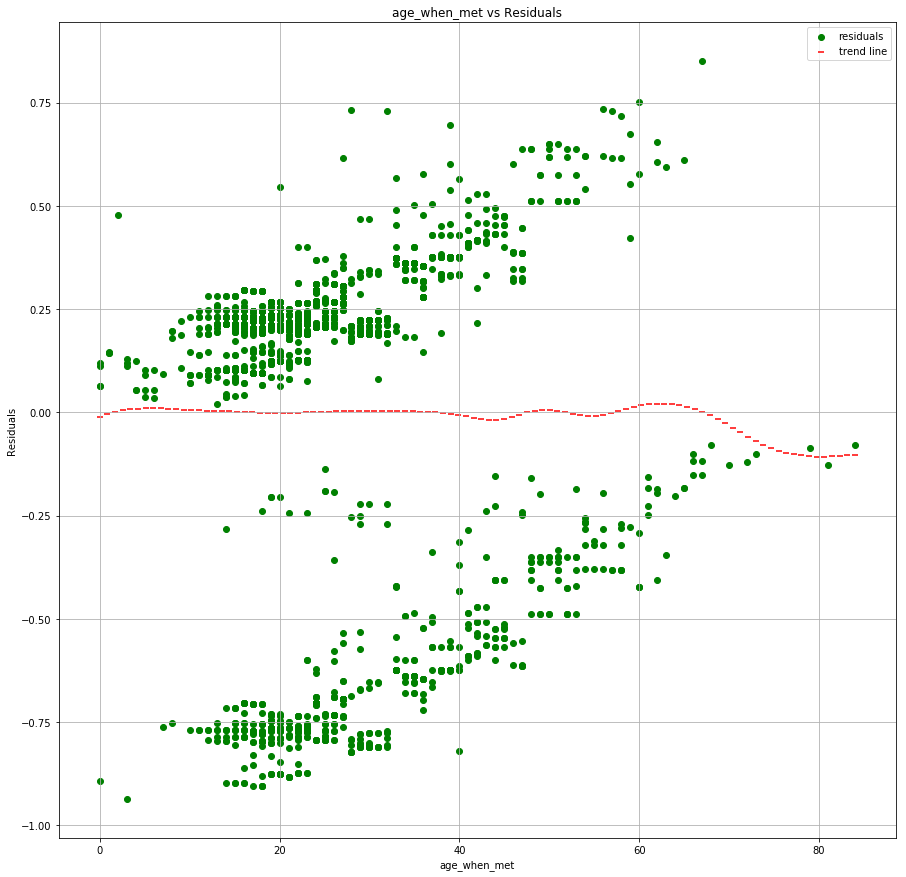

In [20]:
names = ["age_when_met", "Residuals"]
diagnostic_figure(x_train["age_when_met"].values, res, plot_fn=plot_gam, names=names)

Podobnie jak wyżej, krzywa lokalnego trendu jest różna od krzywej stale równej zero, chociąż oscyluje przy niej od początku, prawie końca przyjmowania wartośi przez zmienną wyznaczającą wiek poznania pary. Koncowe wartości zmiennej wskazują tendencje do poprawnego rozpoznawania, iż para się nie pobrała, gdy ich poznanie nastąpiło po 70 latach od narodzin jednego z partnerów.

# Cook's distance

5. Dla każdej obserwacji policz wartości Cooka o ile zmieniłyby się predykcje modelu gdyby model uczyć na danych bez obserwacji i (miara wpływowości obserwacji i).

In [21]:
def simply_plot(x, y):
    plt.scatter(x, y)
    plt.grid()

In [22]:
def get_fitted_model(x, y):
    clf_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('clf', XGBClassifier(**fix_params))])
    return clf_xgb.fit(x,y)


In [23]:
def compute_loss(x_partial, y_pred, clf):
    y_pred_partial = clf.predict_proba(x_partial)[:, 1]
    return np.square(y_pred_partial - y_pred).sum()


In [24]:
def cooker_dist(x, y):
    cooks_dists = []
    clf = get_fitted_model(x, y)
    y_pred = clf.predict_proba(x)[:, 1]
    s_2_and_p = x.shape[1] * compute_loss(x, y.values.flatten(), clf) / (x.shape[0] - x.shape[1])
    for i in tqdm(x.index):
        x_ = x.drop(index=i)
        y_ = y.drop(index=i)
        local_clf = get_fitted_model(x_, y_)
        cooks_dist = compute_loss(x, y_pred, local_clf)
        cooks_dists.append(cooks_dist)
        
    return np.array(cooks_dists) / s_2_and_p
        

In [25]:
cooks_dist = cooker_dist(x_train, y_train)

100%|██████████| 2195/2195 [02:24<00:00, 15.19it/s]


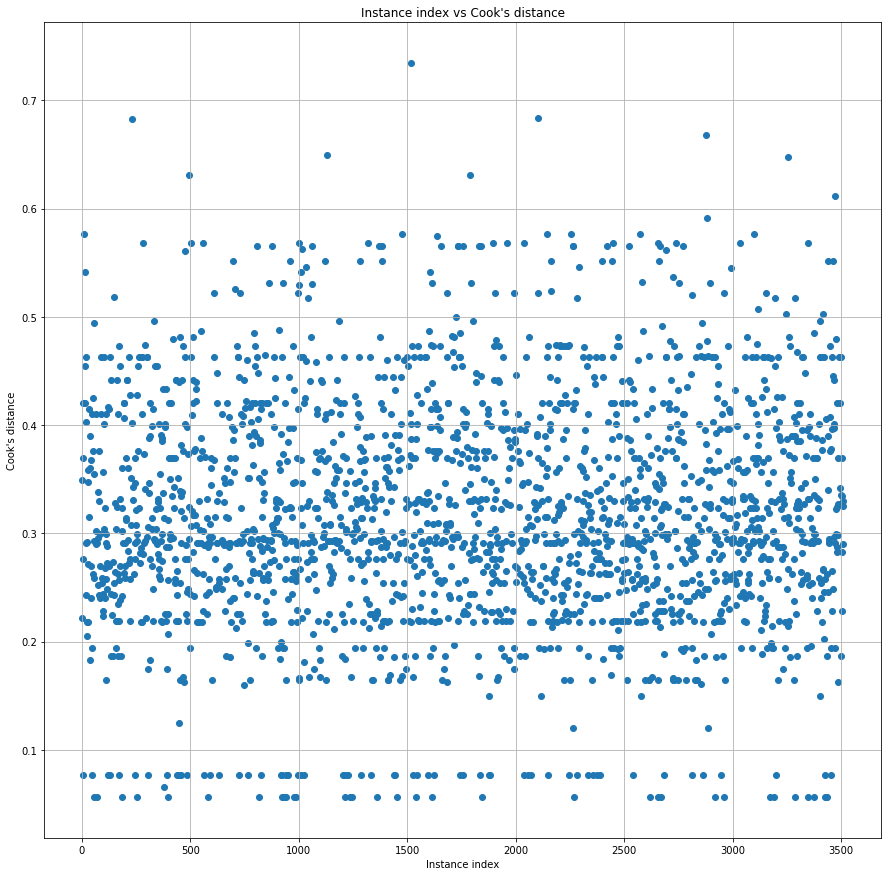

In [26]:
names = ["Instance index", "Cook's distance"]
diagnostic_figure(x_train.index.values, cooks_dist, plot_fn=simply_plot, names=names)

Na podstawie odległości Cook'a, w danych nie można wskazać punktów zasługujących na dokładnieszy ogląd, t.j. nie widać przykładu, którego usunięcie z danych prowadzi do stworzenia modelu wyróżniającego się spośród modeli utworzonych w podobny sposób.